In [1]:
# Install dependencies
!pip install imblearn xgboost --quiet

In [2]:
# Parkinson's Disease Prediction Pipeline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Step 1: Load dataset
df = pd.read_csv('/content/parkinsons.data')
print("Data loaded successfully.")

Data loaded successfully.


In [10]:
print(df.shape)

(195, 24)


In [13]:
display(df.head())

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [14]:
# Step 2: Drop the 'name' column
df.drop(['name'], axis=1, inplace=True)

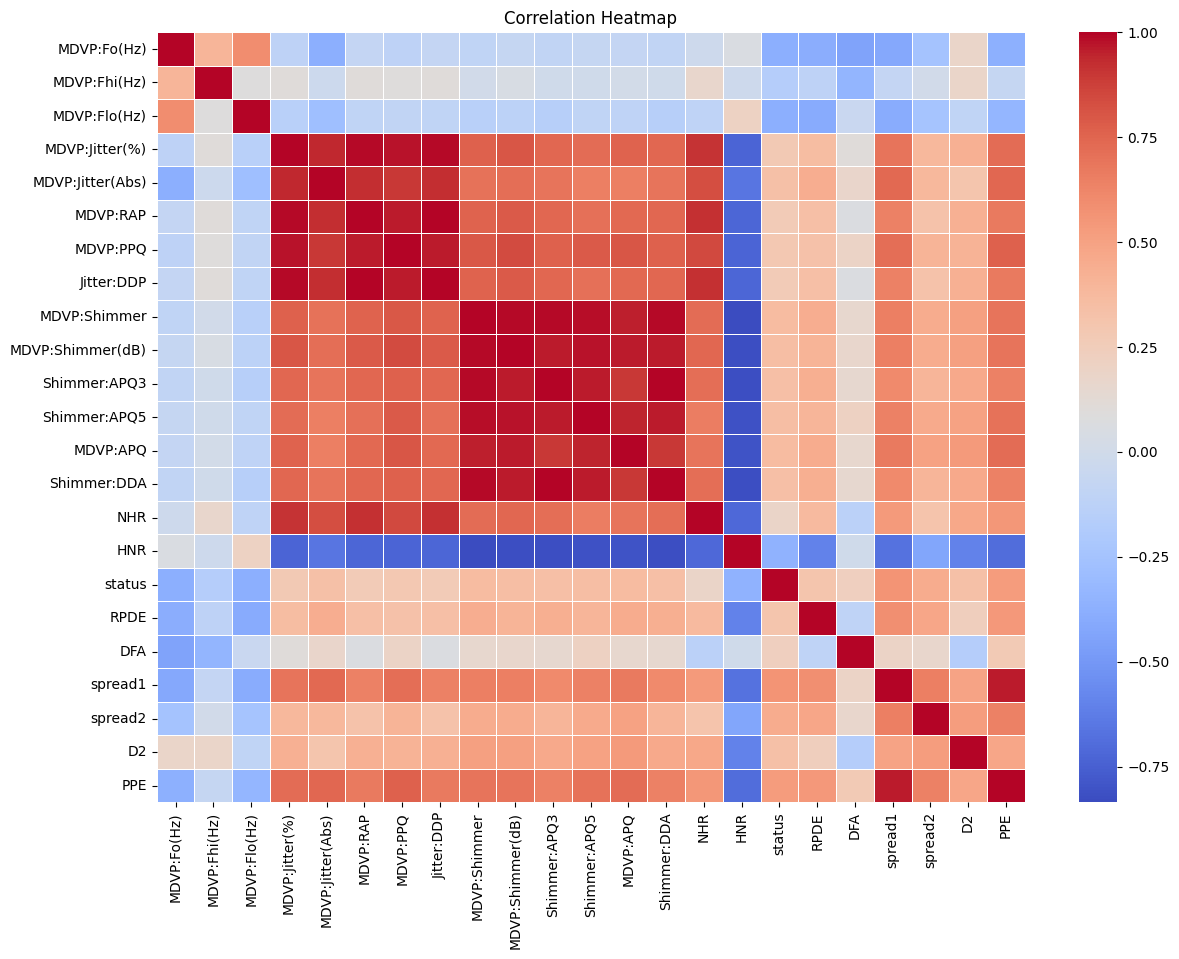

In [15]:
# Step 2.5: Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [16]:
# Step 3: Outlier removal using IQR
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return upper, lower

In [17]:
print("\nRemoving outliers...")
features = df.columns.drop('status')
for col in features:
    upper, lower = detect_outliers(df, col)
    df = df[(df[col] > lower) & (df[col] < upper)]

print("Data shape after outlier removal:", df.shape)


Removing outliers...
Data shape after outlier removal: (125, 23)


In [18]:
# Step 4: Split features and target
X = df.drop('status', axis=1)
y = df['status']
print("\nTarget distribution:\n", y.value_counts())


Target distribution:
 status
1    92
0    33
Name: count, dtype: int64


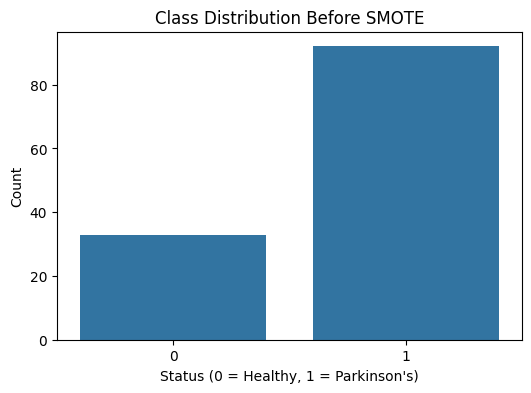

In [19]:
# Step 4.5: Plot class distribution before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Status (0 = Healthy, 1 = Parkinson's)")
plt.ylabel("Count")
plt.show()

In [20]:
# Step 5: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Step 6: Handle class imbalance using SMOTE
print("\nBalancing dataset using SMOTE...")
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)
print("After SMOTE - target distribution:\n", pd.Series(y_res).value_counts())


Balancing dataset using SMOTE...
After SMOTE - target distribution:
 status
1    92
0    92
Name: count, dtype: int64


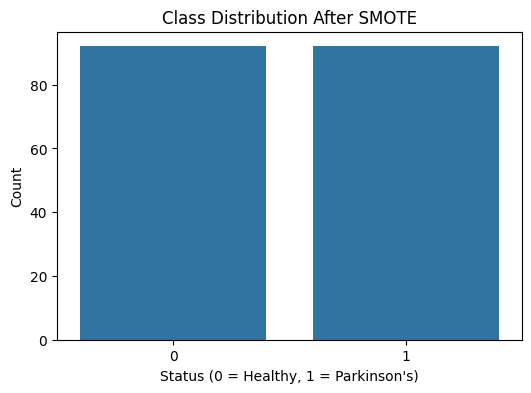

In [22]:
# Step 6.5: Plot class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Status (0 = Healthy, 1 = Parkinson's)")
plt.ylabel("Count")
plt.show()

In [23]:
# Step 7: Feature selection (Top 10)
selector = RFE(RandomForestClassifier(), n_features_to_select=10)
X_selected = selector.fit_transform(X_res, y_res)
selected_feature_mask = selector.support_
selected_features = X.columns[selected_feature_mask]
print("Top 10 features selected:", list(selected_features))

Top 10 features selected: ['MDVP:Fo(Hz)', 'MDVP:Flo(Hz)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:APQ', 'NHR', 'spread1', 'D2', 'PPE']


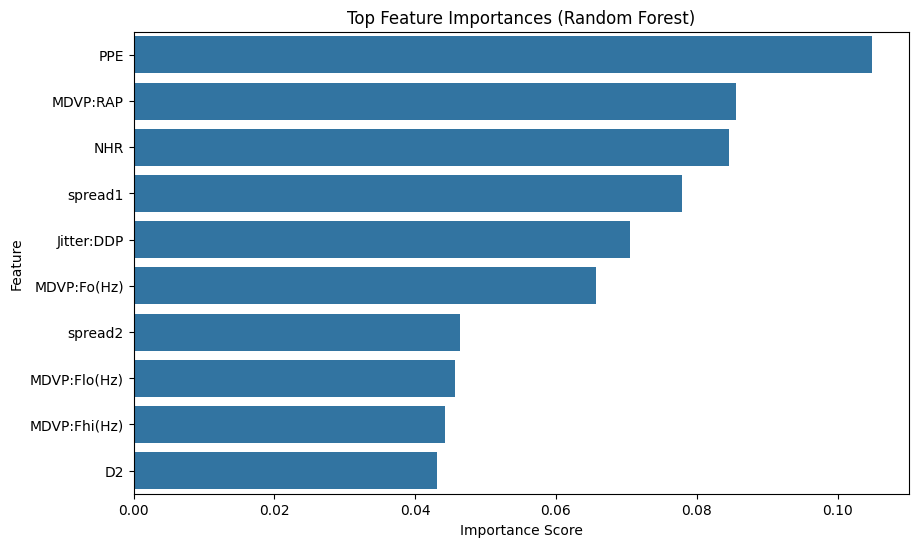

In [24]:
# Step 7.5: Visualize feature importances
rf_temp = RandomForestClassifier()
rf_temp.fit(X_res, y_res)
importances = rf_temp.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [25]:
# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_res, test_size=0.2, random_state=42)
print(f"\nTraining samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")


Training samples: 147 | Test samples: 37


In [26]:
# Step 9: Define VotingClassifier model
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('svm', SVC(probability=True))
], voting='soft')

In [27]:
# Step 10: Train the model
print("\nTraining ensemble model...")
voting_clf.fit(X_train, y_train)

# Step 11: Make predictions and evaluate
y_pred = voting_clf.predict(X_test)

print("\nAccuracy Score:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Training ensemble model...

Accuracy Score: 0.8378

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.83      0.83      0.83        18

    accuracy                           0.84        37
   macro avg       0.84      0.84      0.84        37
weighted avg       0.84      0.84      0.84        37



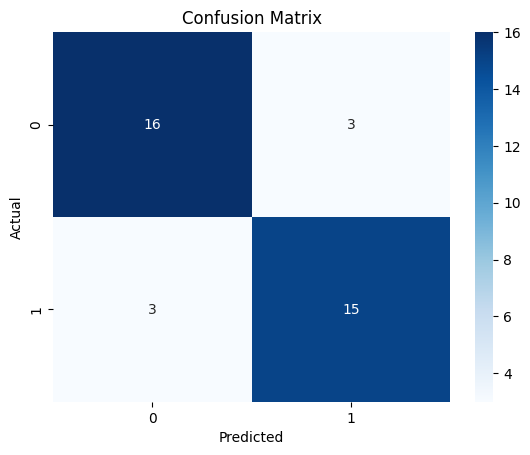


Cross-Validation Scores: [0.91891892 0.7027027  0.78378378 0.83783784 1.        ]
Mean Cross-Validation Accuracy: 0.8486


In [28]:
# Step 12: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 13: Cross-validation scores
cv_scores = cross_val_score(voting_clf, X_selected, y_res, cv=5)
print("\nCross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", round(cv_scores.mean(), 4))